In [ ]:
!pip install torch torchvision torchinfo ptflops pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from ptflops import get_model_complexity_info
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

In [ ]:
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
GPU Name: Tesla T4


In [ ]:
# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# DataLoader (modify batch_size/workers here)
train_loader = DataLoader(
    train_data,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


In [ ]:
import os
import psutil
import torch

print("\n=== Google Colab Machine Specs ===")

# GPU Details
if torch.cuda.is_available():
    print("\n**GPU Information**")
    print(f"- Device Name: {torch.cuda.get_device_name(0)}")
    print(f"- CUDA Version: {torch.version.cuda}")
    print(f"- Total VRAM: {round(torch.cuda.get_device_properties(0).total_memory/1e9, 2)} GB")
    !nvidia-smi --query-gpu=name,driver_version,memory.total --format=csv
else:
    print("\n**No GPU detected**")

# CPU/RAM/Disk
print("\n**CPU & Memory**")
!cat /proc/cpuinfo | grep 'model name' | uniq  # CPU model
print(f"- Cores: {os.cpu_count()} logical cores")
print(f"- RAM: {round(psutil.virtual_memory().total / 1e9, 2)} GB")
print(f"- Disk: {round(psutil.disk_usage('/').total / 1e9, 2)} GB total")

# Software Versions
print("\n**Software Versions**")
print(f"- Python: {os.sys.version}")
print(f"- PyTorch: {torch.__version__}")
print(f"- CUDA: {torch.version.cuda if torch.cuda.is_available() else 'N/A'}")
print(f"- OS: {os.uname().sysname} {os.uname().release}")


=== Google Colab Machine Specs ===

**GPU Information**
- Device Name: Tesla T4
- CUDA Version: 12.4
- Total VRAM: 15.83 GB
name, driver_version, memory.total [MiB]
Tesla T4, 550.54.15, 15360 MiB

**CPU & Memory**
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
- Cores: 2 logical cores
- RAM: 13.61 GB
- Disk: 120.94 GB total

**Software Versions**
- Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
- PyTorch: 2.6.0+cu124
- CUDA: 12.4
- OS: Linux 6.1.85+


In [ ]:
!pip install torchinfo --upgrade

In [ ]:
from torchinfo import summary

def compute_metrics(model, batch_size=128):
    device = next(model.parameters()).device

    # Flops and Parameters
    macs, params = get_model_complexity_info(
        model, (3, 32, 32),
        as_strings=False,
        input_constructor=lambda _: {"x": torch.randn(1, 3, 32, 32).to(device)}
    )
    flops = 2 * macs  # Convert MACs to FLOPs

    # Model summary to get activation memory
    model_summary = summary(
        model,
        input_size=(batch_size, 3, 32, 32),
        verbose=0  
    )

    # Extract metrics from summary
    params_mem = params * 4  # Parameters memory (bytes)
    input_mem = 3 * 32 * 32 * 4 * batch_size  # Inputs memory (bytes)
    activation_mem = model_summary.forward_backward_bytes  # Activation memory (bytes)

    # Total memory accessed (weights + inputs + 2*activations)
    # multiply by two as it will take input and also give output
    total_mem = params_mem + input_mem + 2 * activation_mem

    return {
        "FLOPs (G)": flops / 1e9,
        "Params (M)": params / 1e6,
        "Memory Accessed (GB)": total_mem / 1e9,
        "Operational Intensity (FLOPs/Byte)": flops / total_mem
    }

In [ ]:
def compute_complexity(model, batch_size=128):
    """Calculate theoretical metrics with activation memory"""
    model = model.to(device)

    # FLOPs and parameters
    macs, params = get_model_complexity_info(
        model,
        (3, 32, 32),
        input_constructor=lambda _: {"x": torch.randn(1, 3, 32, 32).to(device)},
        as_strings=False,
        verbose=False
    )
    flops = 2 * macs

    # Memory calculation (weights + inputs + 2*activations)
    model_summary = summary(
        model,
        input_size=(batch_size, 3, 32, 32),
        verbose=0,z
        device=device
    )

    params_mem = params * 4  # 4 bytes per parameter
    input_mem = 3*32*32 * 4 * batch_size  # Input tensor memory
    activation_mem = model_summary.total_output_bytes * 2  # Forward + backward

    total_mem = params_mem + input_mem + activation_mem

    return {
        "FLOPs (G)": flops / 1e9,
        "Params (M)": params / 1e6,
        "Memory Accessed (GB)": total_mem / 1e9,
        "Operational Intensity": flops / total_mem  # FLOPs/Byte
    }

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def run_lenet():
    model = LeNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Reset peak memory stats before profiling
    torch.cuda.reset_peak_memory_stats()

    # Get theoretical metrics (including Operational Intensity)
    theory_metrics = compute_complexity(model)

    start_time = time.time()
    with profile(activities=[ProfilerActivity.CUDA], profile_memory=True) as prof:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            break  # Profile one batch

    time_per_batch = (time.time() - start_time) * 1000  # in ms
    mem_usage = torch.cuda.max_memory_allocated() / 1e6   # in MB

    return {
        **theory_metrics,  # includes: "FLOPs (G)", "Params (M)", "Memory Accessed (GB)", "Operational Intensity"
        'Model': 'LeNet-5',
        'Memory Usage (MB)': mem_usage,
        'Time/Batch (ms)': time_per_batch,
        'FLOPs/sec (T)': (theory_metrics["FLOPs (G)"] * 1e9) / (time_per_batch / 1000) / 1e12
        # FLOPs/sec in TeraFLOPs/sec
    }

lenet_results = run_lenet()
print("LeNet Results:", lenet_results)


Warning! No positional inputs found for a module, assuming batch size is 1.
LeNet(
  62.01 k, 100.000% Params, 664.54 KMac, 99.060% MACs, 
  (conv1): Conv2d(456, 0.735% Params, 357.5 KMac, 53.292% MACs, 3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(0, 0.000% Params, 6.3 KMac, 0.940% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2.42 k, 3.896% Params, 241.6 KMac, 36.014% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(48.12 k, 77.605% Params, 48.12 KMac, 7.173% MACs, in_features=400, out_features=120, bias=True)
  (fc2): Linear(10.16 k, 16.392% Params, 10.16 KMac, 1.515% MACs, in_features=120, out_features=84, bias=True)
  (fc3): Linear(850, 1.371% Params, 850.0 Mac, 0.127% MACs, in_features=84, out_features=10, bias=True)
)
LeNet Results: {'FLOPs (G)': 0.001341692, 'Params (M)': 0.062006, 'Memory Accessed (GB)': 0.015169752, 'Operational Intensity': 0.08844521650716505, 'Model': 'LeNet-5', 'Memory Usage (MB)': 11

In [ ]:
resnet18 = models.resnet18(num_classes=10)

In [ ]:
def run_resnet():
    model = resnet18.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    torch.cuda.reset_peak_memory_stats()
    theory_metrics = compute_complexity(model)

    start_time = time.time()
    with profile(activities=[ProfilerActivity.CUDA], profile_memory=True) as prof:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            break

    time_per_batch = (time.time() - start_time) * 1000
    mem_usage = torch.cuda.max_memory_allocated() / 1e6

    return {
        **theory_metrics,
        'Model': 'ResNet-18',
        'Memory Usage (MB)': mem_usage,
        'Time/Batch (ms)': time_per_batch,
        'FLOPs/sec (T)': (theory_metrics["FLOPs (G)"] * 1e9) / (time_per_batch / 1000) / 1e12
    }

resnet_results = run_resnet()
print("ResNet Results:", resnet_results)


Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet(
  11.18 M, 100.000% Params, 37.18 MMac, 99.828% MACs, 
  (conv1): Conv2d(9.41 k, 0.084% Params, 2.41 MMac, 6.466% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.001% Params, 32.77 KMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0, 0.000% Params, 16.38 KMac, 0.044% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 16.38 KMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    147.97 k, 1.323% Params, 9.49 MMac, 25.469% MACs, 
    (0): BasicBlock(
      73.98 k, 0.662% Params, 4.74 MMac, 12.735% MACs, 
      (conv1): Conv2d(36.86 k, 0.330% Params, 2.36 MMac, 6.334% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.001% Params, 8.19 KMac, 0.022% MACs, 64, eps=1e-05, momentum

In [ ]:
class SimpleTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Linear(32*32*3, 512)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = self.embed(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.fc(x)

In [ ]:
def run_transformer():
    model = SimpleTransformer().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    torch.cuda.reset_peak_memory_stats()
    theory_metrics = compute_complexity(model)

    start_time = time.time()
    with profile(activities=[ProfilerActivity.CUDA], profile_memory=True) as prof:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            break

    time_per_batch = (time.time() - start_time) * 1000
    mem_usage = torch.cuda.max_memory_allocated() / 1e6

    return {
        **theory_metrics,
        'Model': 'Transformer',
        'Memory Usage (MB)': mem_usage,
        'Time/Batch (ms)': time_per_batch,
        'FLOPs/sec (T)': (theory_metrics["FLOPs (G)"] * 1e9) / (time_per_batch / 1000) / 1e12
    }

transformer_results = run_transformer()
print("Transformer Results:", transformer_results)


Warning! No positional inputs found for a module, assuming batch size is 1.
SimpleTransformer(
  7.88 M, 100.000% Params, 7.88 MMac, 100.000% MACs, 
  (embed): Linear(1.57 M, 19.958% Params, 1.57 MMac, 19.956% MACs, in_features=3072, out_features=512, bias=True)
  (transformer): TransformerEncoder(
    6.3 M, 79.977% Params, 6.31 MMac, 79.979% MACs, 
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        3.15 M, 39.988% Params, 3.15 MMac, 39.990% MACs, 
        (self_attn): MultiheadAttention(
          1.05 M, 13.327% Params, 1.05 MMac, 13.345% MACs, 
          (out_proj): NonDynamicallyQuantizableLinear(0, 0.000% Params, 0.0 Mac, 0.000% MACs, in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(1.05 M, 13.327% Params, 1.05 MMac, 13.325% MACs, in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
        (linear2): Linear(1.05 M, 13.308% Params, 1.05 MMac

In [ ]:
results = [lenet_results, resnet_results, transformer_results]
df = pd.DataFrame(results)
print("\nFinal Results:")
print(df.to_markdown(index=False))
df.to_csv('performance_results.csv', index=False)


Final Results:
|   FLOPs (G) |   Params (M) |   Memory Accessed (GB) |   Operational Intensity | Model       |   Memory Usage (MB) |   Time/Batch (ms) |   FLOPs/sec (T) |
|------------:|-------------:|-----------------------:|------------------------:|:------------|--------------------:|------------------:|----------------:|
|  0.00134169 |     0.062006 |              0.0151698 |               0.0884452 | LeNet-5     |             115.491 |           620.857 |     2.16103e-06 |
|  0.0744919  |    11.1816   |              0.253938  |               0.293347  | ResNet-18   |             324.759 |           438.748 |     0.000169783 |
|  0.0157686  |     7.88327  |              0.0488551 |               0.322763  | Transformer |             301.541 |           408.583 |     3.85935e-05 |


In [ ]:
def plot_roofline_t4_gpu(results_df):

    # T4 GPU specs 
    peak_flops = 8.1e12       # 8.1 TFLOPs (peak compute performance in FLOPs/sec)
    peak_bandwidth = 320e9    # 320 GB/s memory bandwidth (in Bytes/sec)

    plt.figure(figsize=(12, 8))

    x_values = []  # Operational intensity (FLOPs/Byte)
    y_values = []  # Achieved performance (FLOPs/sec)
    labels = []

    for _, row in results_df.iterrows():
        op_intensity = row.get('Operational Intensity',
                           (row['FLOPs (G)'] * 1e9) / (row['Memory Accessed (GB)'] * 1e9))
        perf = row['FLOPs/sec (T)'] * 1e12

        x_values.append(op_intensity)
        y_values.append(perf)
        labels.append(row['Model'])

    # Generating the theoretical roofline curve with the followiing
    # performance = min(peak_compute, OI * peak_bandwidth)
    x_roof = np.logspace(-2, 4, 1000)  # Define a wide range of OI values (FLOPs/Byte)
    y_roof = np.minimum(peak_flops, x_roof * peak_bandwidth)

    plt.loglog(x_roof, y_roof, 'k-', linewidth=2, label='Roofline')

    # Calculating the ridge point for memory and compute bound region
    ridge_point = peak_flops / peak_bandwidth  # in FLOPs/Byte
    plt.axvline(x=ridge_point, color='gray', linestyle='--', alpha=0.7,
                label=f'Ridge Point: {ridge_point:.2f} FLOPs/Byte')

    # Ploting a horizontal line for the compute-bound (peak compute) region
    plt.axhline(y=peak_flops, color='red', linestyle='--', alpha=0.7,
                label=f'Peak Performance: {peak_flops/1e12:.2f} TFLOPs')

    plt.scatter(x_values, y_values, s=200, c='blue', zorder=5, label='Measured Points')

    for i, label in enumerate(labels):
        plt.annotate(label, (x_values[i]*1.1, y_values[i]*0.9), fontsize=12)

    plt.text(ridge_point * 0.5, peak_flops * 0.7, "Memory-Bound Region",
             ha='center', fontsize=11, alpha=0.7)
    plt.text(ridge_point * 3, peak_flops * 0.7, "Compute-Bound Region",
             ha='center', fontsize=11, alpha=0.7)

    plt.xlabel('Operational Intensity (FLOPs/Byte)', fontsize=14)
    plt.ylabel('Performance (FLOPs/sec)', fontsize=14)
    plt.title('Roofline Model - Google Colab (T4 GPU)', fontsize=16)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.legend(loc='lower right', fontsize=12)

    plt.savefig('roofline_t4_gpu.png', dpi=300, bbox_inches='tight')
    plt.show()


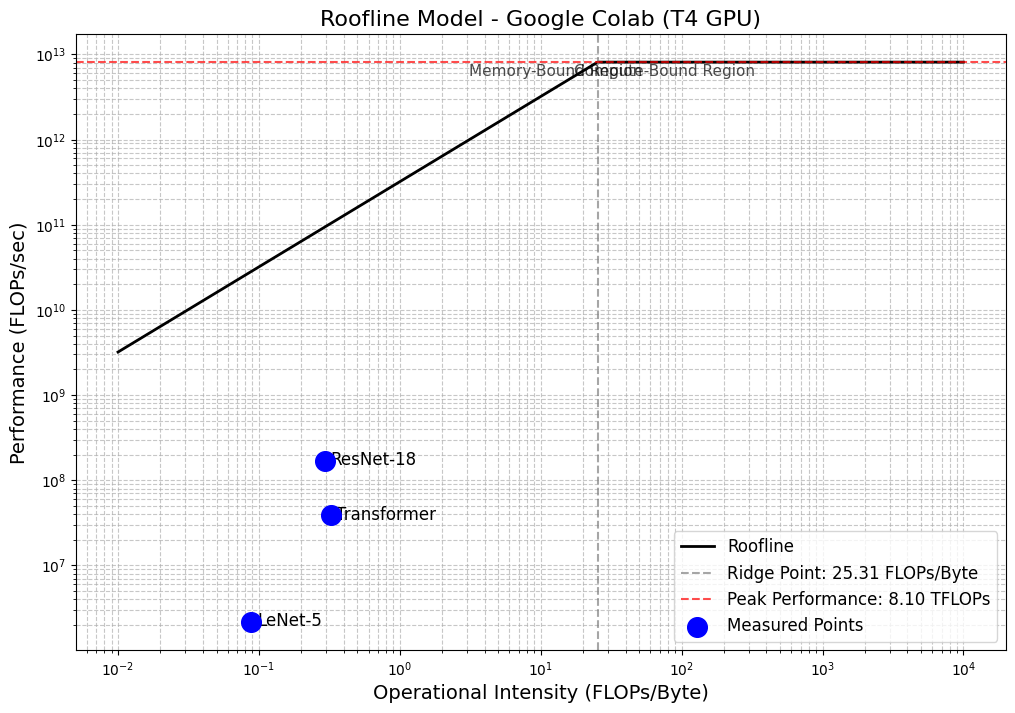

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


results = [lenet_results, resnet_results, transformer_results]
results_df = pd.DataFrame(results)

plot_roofline_t4_gpu(results_df)
